In [ ]:
!pip install pyspark
!pip install mido
!pip install music21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=31f9e36a6624f7acdc8c3f285e9215e20384d0f55ff761bd2fe84c0f835a13de
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from mido import MidiFile
import IPython
import matplotlib.pyplot as plt
import librosa.display
import keras.layers as L
import keras.models as M
import keras
from keras.layers import SimpleRNN,LSTM,GRU
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, LSTM, Conv2DTranspose, Conv2D, LeakyReLU, GlobalMaxPooling2D, Reshape, Flatten, BatchNormalization, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
# from keras.layers.embeddings import Embedding
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam

from sklearn.model_selection import train_test_split
from IPython import *
import os
import tensorflow as tf

from numpy.random import choice

from mido import Message, MidiFile, MidiTrack
import tensorflow as tf
import datetime


In [ ]:
with open(r"gs://cs649project/CS649Data/X_rdd.pickle", "rb") as input_file:
   X_rdd = cPickle.load(input_file)

with open(r"gs://cs649project/CS649Data/y_rdd.pickle", "rb") as input_file:
   y_rdd = cPickle.load(input_file)

In [ ]:
def data_generator(X_rdd, y_rdd):
    
    x=X_rdd.map(lambda x: x).collect()
    y=y_rdd.map(lambda x: x).collect()[0]
    while 1:
        for i,j in zip(x,y):
            yield (i, j)

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)

Plain LSTM

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
model = Sequential()
model.add(LSTM(512,return_sequences=False, input_shape=(phrase_len, 3)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='relu'))
model.compile(loss='mae', optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy])

model.fit(data_generator(X_rdd, y_rdd), epochs=500, validation_split=0.2, callbacks=[tensorboard_callback, lr_callback, reduce_lr])

Epoch 1/500
40/40 [==============================] - 8s 70ms/step - loss: 60.7818 - categorical_accuracy: 0.4083 - val_loss: 58.4954 - val_categorical_accuracy: 0.1628 - lr: 0.0010
Epoch 2/500
40/40 [==============================] - 2s 52ms/step - loss: 53.4005 - categorical_accuracy: 0.4335 - val_loss: 31.8816 - val_categorical_accuracy: 0.1466 - lr: 0.0010
Epoch 3/500
40/40 [==============================] - 2s 53ms/step - loss: 42.1048 - categorical_accuracy: 0.4367 - val_loss: 23.3175 - val_categorical_accuracy: 0.1526 - lr: 0.0010
Epoch 4/500
40/40 [==============================] - 2s 56ms/step - loss: 28.6446 - categorical_accuracy: 0.5544 - val_loss: 30.6802 - val_categorical_accuracy: 0.8142 - lr: 0.0010
Epoch 5/500
40/40 [==============================] - 2s 60ms/step - loss: 22.6755 - categorical_accuracy: 0.6777 - val_loss: 17.4309 - val_categorical_accuracy: 0.8142 - lr: 0.0010
Epoch 6/500
40/40 [==============================] - 2s 60ms/step - loss: 21.4343 - categorical

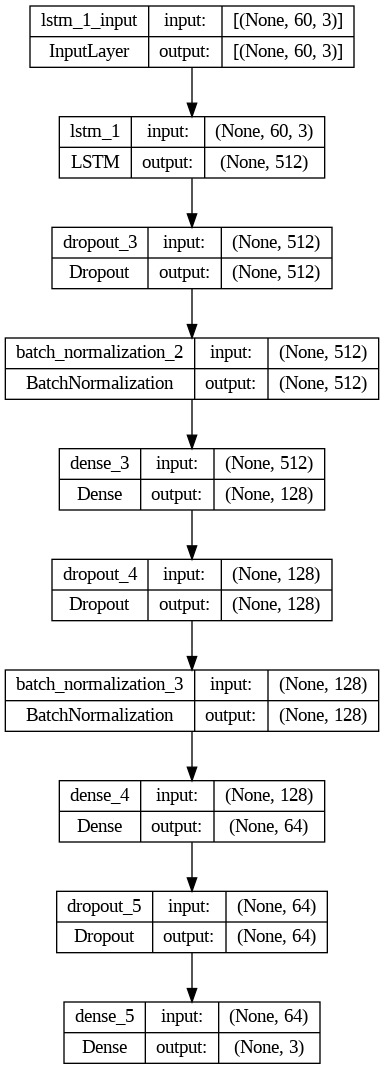

In [ ]:
tf.keras.utils.plot_model(model, to_file='./PlainLSTM.png', show_shapes=True)

LSTM with Embedding

In [ ]:
X = X_rdd.collect()
y = y_rdd.collect()

n_notes = 128
embed_size = 100
phrase_len = 60
notes_in = Input(shape = (phrase_len,))
durations_in = Input(shape = (phrase_len,1))

notes_embed = Embedding(n_notes, embed_size)(notes_in)

concat_model = Concatenate()([notes_embed,durations_in])
concat_model = Dropout(0.3)(concat_model)
concat_model = LSTM(512, return_sequences=False)(concat_model)
concat_model = BatchNormalization()(concat_model)

notes_out = Dense(n_notes, activation = 'softmax', name = 'note')(concat_model)
durations_out = Dense(1, activation = 'relu', name = 'duration')(concat_model)

embed_model = Model([notes_in, durations_in], [notes_out, durations_out])
embed_model.compile(loss=['sparse_categorical_crossentropy', 
                    'mse'], optimizer=RMSprop(lr = 0.001))

train_chords = X[:, :, 1]
train_durations = X[:, :, 0]
target_chords = y[:, 1]
target_durations = y[:, 0]



In [ ]:
train_chords_rdd = sc.parallelize(train_chords)
train_durations_rdd = sc.parallelize(train_durations)
target_chords_rdd = sc.parallelize(target_chords)
target_durations_rdd = sc.parallelize(target_durations)

In [ ]:
def data_generator(train_chords_rdd, train_durations_rdd, target_chords_rdd, target_durations_rdd):
    

    train_chords = train_chords_rdd.map(lambda x: x).collect()
    train_durations = train_durations_rdd.map(lambda x: x).collect()
    target_chords =target_chords_rdd.map(lambda x: x).collect()
    target_durations = target_durations_rdd.map(lambda x: x).collect()
    while 1:
        for i,j,k,l in zip(train_chords,train_durations,target_chords,target_durations):
            yield ([i,j], [k,l])

In [ ]:
from keras import callbacks
embed_model.fit(data_generator(train_chords_rdd, train_durations_rdd, target_chords_rdd, target_durations_rdd), epochs=500, batch_size=256, validation_split=0.2, callbacks=[tensorboard_callback, lr_callback, reduce_lr]
                  )

Epoch 1/500
40/40 [==============================] - 13s 107ms/step - loss: 19157.9766 - note_loss: 4.9788 - duration_loss: 19152.9980 - val_loss: 11354.4375 - val_note_loss: 4.8738 - val_duration_loss: 11349.5654 - lr: 0.0010
Epoch 2/500
40/40 [==============================] - 2s 61ms/step - loss: 18729.3848 - note_loss: 4.8802 - duration_loss: 18724.5117 - val_loss: 11501.4795 - val_note_loss: 4.7984 - val_duration_loss: 11496.6807 - lr: 0.0010
Epoch 3/500
40/40 [==============================] - 2s 60ms/step - loss: 18333.7539 - note_loss: 4.7057 - duration_loss: 18329.0508 - val_loss: 11458.3301 - val_note_loss: 4.8828 - val_duration_loss: 11453.4463 - lr: 0.0010
Epoch 4/500
40/40 [==============================] - 2s 54ms/step - loss: 18151.8887 - note_loss: 4.5545 - duration_loss: 18147.3340 - val_loss: 11034.4004 - val_note_loss: 5.0333 - val_duration_loss: 11029.3672 - lr: 0.0010
Epoch 5/500
40/40 [==============================] - 2s 54ms/step - loss: 18564.6445 - note_loss: 

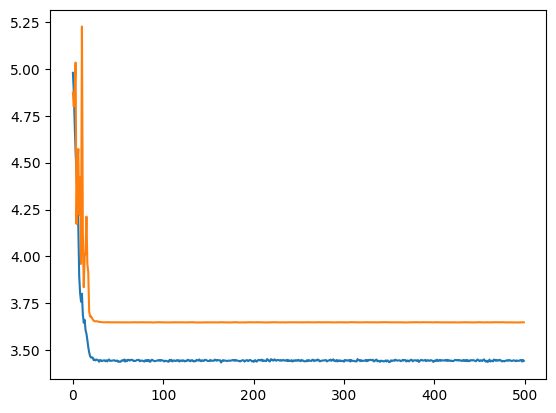

In [ ]:
history=embed_model.history.history
plt.plot([i for i in range(len(history['note_loss']))],history['note_loss'])
plt.plot([i for i in range(len(history['val_note_loss']))],history['val_note_loss'])

In [ ]:
plt.plot([i for i in range(len(history['note_loss']))],history['note_loss'])
plt.plot([i for i in range(len(history['val_note_loss']))],history['val_note_loss'])

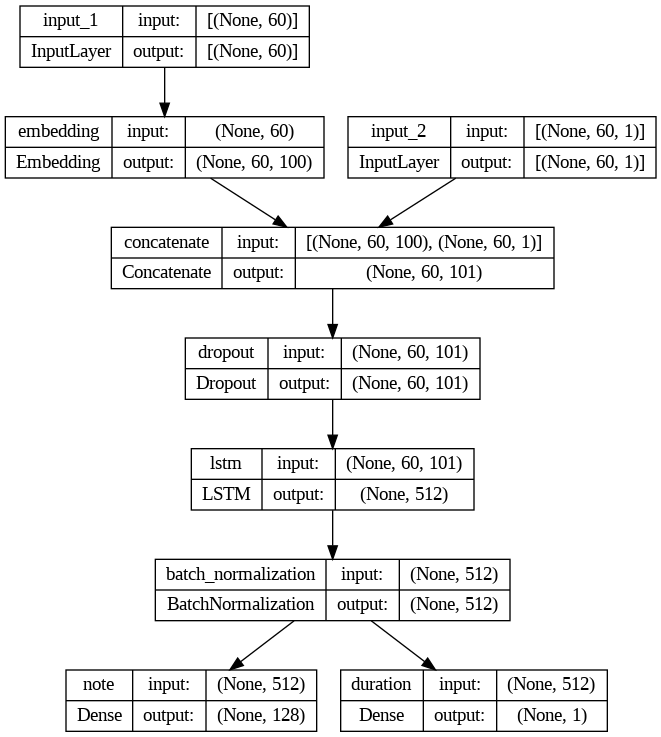

In [ ]:
tf.keras.utils.plot_model(embed_model, to_file='./EmbddLSTM.png', show_shapes=True)

GAN

In [ ]:
u, c = np.unique(X[:, :, 0].sum(axis=1), return_counts=True)
np.median(u)

1828.0

In [ ]:
def tune_to_matrix(tune, tune_len=4000):
    notes_matrix = np.zeros((128, tune_len))
    i = 0
    for n in tune:
        for j in range(int(n[0] / 4)):
            notes_matrix[n[1], i] = 1
            i += 1
            if i == tune_len:
                break
        if i == tune_len:
            break
    return notes_matrix

In [ ]:
X[0, :, 0].sum()
tune_to_matrix(X[0]).sum(axis=1)
tune_len = 200
n_notes = 128

train_matrixes = []
for x in X[:1000]:
    train_matrixes.append(tune_to_matrix(x, tune_len=200))

latent_dim = 64
discriminator = Sequential(
    [
        Input((n_notes, tune_len)),
        Reshape((n_notes, tune_len, 1)),
        Conv2D(4, (8, 4), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(8, (8, 4), padding="same"),
        LeakyReLU(alpha=0.2),
        GlobalMaxPooling2D(),
        Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)
# Create the generator.
generator = Sequential(
    [
        Input((latent_dim,)),
        Dense(n_notes * tune_len * latent_dim),
        Reshape((n_notes, tune_len, latent_dim)),
        Conv2DTranspose(1, (4, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, (4, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(1, (6, 4)),
        Flatten(),
        Dense(n_notes * tune_len, activation='sigmoid'),
        Reshape((n_notes, tune_len)),
    ],
    name="generator",
)
generator.summary()
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.distr = tf.random.uniform

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, real_tunes):
        # Sample random points in the latent space 
        # This is for the generator.
        batch_size = tf.shape(real_tunes)[0]
        random_latent_vectors = self.distr(shape=(batch_size, self.latent_dim))


        # Decode the noise (guided by labels) to fake images.
        generated_tunes= self.generator(random_latent_vectors)
        
        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions_real = self.discriminator(real_tunes)
            predictions_fake = self.discriminator(generated_tunes)
            d_loss = self.d_loss_fn([predictions_fake, predictions_real], [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))])
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = self.distr(shape=(batch_size, self.latent_dim))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_tunes = self.generator(random_latent_vectors)
            predictions = self.discriminator(fake_tunes)
            g_loss = self.g_loss_fn(predictions, tf.zeros((batch_size, 1)))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

dataset = np.array(train_matrixes[:256])
def discriminator_loss(pred, labels):
    real_loss = tf.reduce_mean(pred[1])
    fake_loss = tf.reduce_mean(pred[0])
    return real_loss - 2 * fake_loss


def generator_loss(pred, labels):
    return tf.reduce_mean(pred)

gan = GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.000005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

gan.fit(dataset, epochs=60)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1638400)           106496000 
                                                                 
 reshape_1 (Reshape)         (None, 128, 200, 64)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 200, 1)      513       
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128, 200, 1)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 200, 1)      9         
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 200, 1)       0 

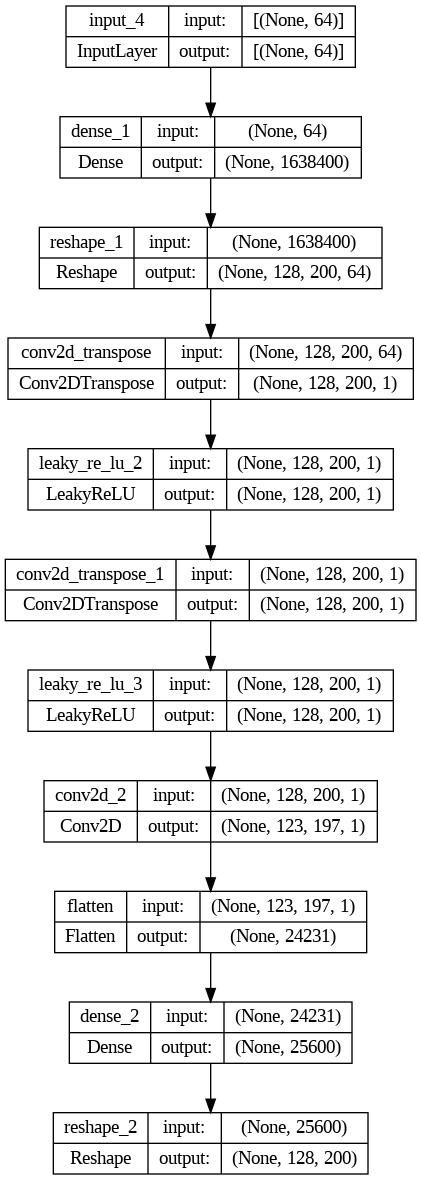

In [ ]:
tf.keras.utils.plot_model(generator, to_file='./GAN.png', show_shapes=True)
# gan.summary()

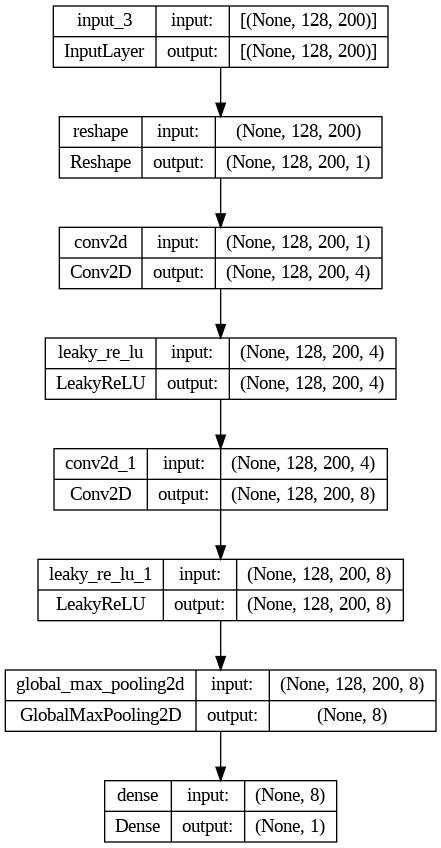

In [ ]:
tf.keras.utils.plot_model(discriminator, to_file='./GAN_1.png', show_shapes=True)


In [ ]:
gan.fit(dataset, epochs=60)